In [102]:
import numpy as np
import math
import matplotlib.pyplot as plt
from skimage.segmentation import slic
from skimage.color import label2rgb
from skimage.io import imread
import cv2
from skimage import color
import numpy.linalg as la
import os
import shutil
from tqdm import tqdm

In [103]:
def generate_superpixels(image_path, k):
    """
    Generates and displays superpixels for a given image using the SLIC algorithm.

    Parameters:
    - image_path: Path to the image file.
    - k: The desired number of superpixels.

    Returns:
    - A visualization of the superpixels overlaid on the original image.
    """

    # Load the image
    image = imread(image_path)

    # Apply SLIC and obtain the segment labels
    segments = slic(image, n_segments=k, compactness=10,
                    sigma=1, start_label=1)

    # Create an image showing the superpixel boundaries
    superpixels = label2rgb(segments, image, kind='avg')

    # Display the results
    fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
    ax[0].imshow(image)
    ax[0].set_title('Original Image')
    ax[1].imshow(superpixels)
    ax[1].set_title(f'Superpixels with k={k}')

    for a in ax:
        a.axis('off')

    plt.tight_layout()
    plt.show()

    return superpixels

# Example usage:
# generate_superpixels('path_to_your_image.jpg', k=200)


In [104]:
test_path = './logo-dataset/volkswagen/images/'


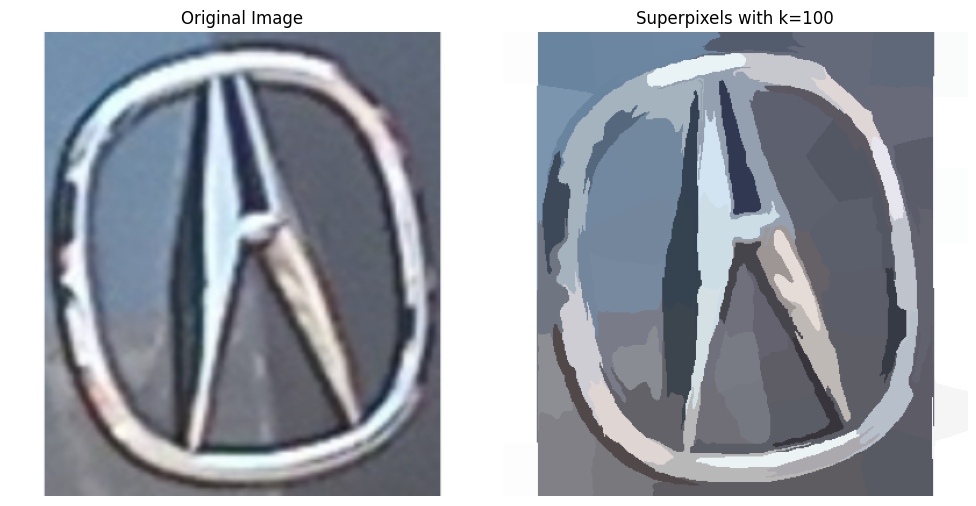

array([[[253, 253, 253],
        [253, 253, 253],
        [253, 253, 253],
        ...,
        [250, 251, 251],
        [250, 251, 251],
        [250, 251, 251]],

       [[253, 253, 253],
        [253, 253, 253],
        [253, 253, 253],
        ...,
        [250, 251, 251],
        [250, 251, 251],
        [250, 251, 251]],

       [[253, 253, 253],
        [253, 253, 253],
        [253, 253, 253],
        ...,
        [250, 251, 251],
        [250, 251, 251],
        [250, 251, 251]],

       ...,

       [[253, 253, 253],
        [253, 253, 253],
        [253, 253, 253],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[253, 253, 253],
        [253, 253, 253],
        [253, 253, 253],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[253, 253, 253],
        [253, 253, 253],
        [253, 253, 253],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

In [89]:
generate_superpixels('./logo-dataset/acura/0aa5a789508cd718fc4cf044352375ed54080b5e.png', 100)


In [106]:
def calculate_gradient_sobel(image):
    # grayscale image
    if len(image.shape) > 2:
        image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        image_gray = image

    # calculate the gradients using sobel
    # use cv2.CV_64F to accommodate the result gradients
    grad_x = cv2.Sobel(image_gray, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(image_gray, cv2.CV_64F, 0, 1, ksize=3)

    # calculate gradient magnitude
    gradient_magnitude = np.sqrt(grad_x**2 + grad_y**2)

    # normalize gradient magnitude
    gradient_magnitude_norm = cv2.normalize(
        gradient_magnitude, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_64F)

    return gradient_magnitude_norm


In [107]:
def get_optimized_cluster_centers(image, K):
    height, width = image.shape[:2]
    S = int(np.sqrt(height * width / K))
    cluster_centers = []

    # compute gradient using sobel
    gradient = calculate_gradient_sobel(image)

    for i in range(0, height - S, S):
        for j in range(0, width - S, S):
            center_i, center_j = i + S // 2, j + S // 2

            # neighborhood around the tentative center
            neighborhood_size = S // 4
            min_pos = (center_i, center_j)
            min_gradient = gradient[center_i, center_j]

            for ni in range(max(0, center_i - neighborhood_size), min(height, center_i + neighborhood_size + 1)):
                for nj in range(max(0, center_j - neighborhood_size), min(width, center_j + neighborhood_size + 1)):
                    if gradient[ni, nj] < min_gradient:
                        min_gradient = gradient[ni, nj]
                        min_pos = (ni, nj)

            cluster_centers.append(min_pos)

    # plt.imshow(gradient, cmap='plasma')
    # plt.colorbar()  # Show gradient magnitude scale
    # plt.scatter([c[1] for c in cluster_centers], [c[0]
    #             for c in cluster_centers], color='red')  # Mark cluster centers
    # plt.show()

    return cluster_centers, gradient


In [108]:
def slic_superpixels(image, K, m, num_iterations=5):

    # convert image to LAB
    lab_image = color.rgb2lab(image)

    height, width = image.shape[:2]

    N = height * width  # total number of pixels in the image
    A = N / K           # area of superpixel
    S = int(np.sqrt(A))  # length of each superpixel

    cluster_centers, gradient = get_optimized_cluster_centers(image, K)

    # initialize labels and distances
    labels = -1 * np.ones(image.shape[:2], np.int32)
    distances = np.inf * np.ones(image.shape[:2], np.float64)

    spatial_scale = m/S

    # SLIC algorithm
    for _ in range(num_iterations):
        for ci, center in enumerate(cluster_centers):
            cx, cy = center
            # search in 2S range
            for i in range(max(0, cx - S), min(height, cx + S)):
                for j in range(max(0, cy - S), min(width, cy + S)):
                    
                    d_lab = math.dist(lab_image[cx, cy], lab_image[i, j])
                    d_spatial = math.dist([cx, cy], [i, j])

                    d = d_lab + spatial_scale * d_spatial

                    if d < distances[i, j]:
                        distances[i, j] = d
                        labels[i, j] = ci

        # update cluster centers
        for ci in range(len(cluster_centers)):
            members = np.where(labels == ci)
            if members[0].size > 0:
                new_center_x = np.mean(members[0])
                new_center_y = np.mean(members[1])
                cluster_centers[ci] = (
                    int(new_center_x), int(new_center_y))

    final_image = np.zeros_like(image)

    for ci in range(len(cluster_centers)):
        members = np.where(labels == ci)
        if members[0].size > 0:
            for channel in range(3):
                final_image[members[0], members[1], channel] = np.mean(image[members[0], members[1], channel])

    return final_image
    # return final_image, labels, cluster_centers, gradient

In [59]:
for root, dirs, files in os.walk('./logo-dataset/alfa/images/'):
    np.random.seed(5)
    for file in np.random.choice(files, 5, replace=False):
        img_path = os.path.join(root, file)
        image = cv2.imread(img_path)
        if image is not None:  # Check if the image was correctly loaded
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            final_img, superpixels, cluster_centers_final, img_gradient = slic_superpixels(
                image, K=125, m=2)

            # Create a figure to hold the subplots
            fig, ax = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns

            # Display the original image on the left
            ax[0].imshow(image)
            ax[0].set_title("Original Image")
            ax[0].axis('off')

            # Display the gradient image with final cluster centers in the middle
            # Assuming img_gradient is a grayscale image
            ax[1].imshow(img_gradient, cmap='gray')
            ax[1].scatter([y for x, y in cluster_centers_final], [
                          x for x, y in cluster_centers_final], color='red', s=5)  # Plotting the cluster centers
            ax[1].set_title("Gradient with Cluster Centers")
            ax[1].axis('off')

            # Display the superpixelated image on the right
            ax[2].imshow(final_img)
            ax[2].set_title("Superpixelated Image")
            ax[2].axis('off')

            plt.show()
        else:
            print(f"Failed to load image: {img_path}")


KeyboardInterrupt: 

In [110]:
dataset_path = './logo-dataset'
model_training_path = './keras-dataset'

# Iterate through each brand's folder
for brand_folder in tqdm(os.listdir(dataset_path)):
    orig_brand_path = os.path.join(dataset_path, brand_folder)
    images_path = orig_brand_path
    slic_images_path = os.path.join(model_training_path, brand_folder)

    # Check if the current folder is a directory
    if os.path.isdir(images_path):
        # Ensure slic_images directory exists
        if not os.path.exists(slic_images_path):
            os.makedirs(slic_images_path)

        # Iterate through each image in the images folder
        for image_name in os.listdir(images_path):
            # Save the processed image
            slic_image_name = f"slic_{image_name}"
            slic_image_path = os.path.join(slic_images_path, slic_image_name)

            # if os.path.exists(slic_image_path):
            #     continue

            formatted_image_name = image_name.replace(' ', '_')
            # Now add the slic_ prefix
            slic_image_name = f"slic_{formatted_image_name}"
            slic_image_path = os.path.join(slic_images_path, slic_image_name)

            img_path = os.path.join(images_path, image_name)
            image = cv2.imread(img_path)

            if image is None:
                print(f"Failed to load image: {img_path}")
                continue

            # Process the image
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            final_img = slic_superpixels(image, K=125, m=2)

            cv2.imwrite(slic_image_path, cv2.cvtColor(
                final_img, cv2.COLOR_RGB2BGR))
            print(f'Processed {slic_image_path}')
    print(f"Processed {brand_folder}")

print("Processing complete.")


  0%|          | 0/24 [00:00<?, ?it/s]

Processed ./keras-dataset/volkswagen/slic_1_org.png
Processed ./keras-dataset/volkswagen/slic_0_org_zoom.png
Processed ./keras-dataset/volkswagen/slic_images241.png
Processed ./keras-dataset/volkswagen/slic_images32.png
Processed ./keras-dataset/volkswagen/slic_images255.png
Processed ./keras-dataset/volkswagen/slic_vw1q.png
Processed ./keras-dataset/volkswagen/slic_images269.png
Processed ./keras-dataset/volkswagen/slic_a31.png
Processed ./keras-dataset/volkswagen/slic_a25.png
Processed ./keras-dataset/volkswagen/slic_a19.png
Processed ./keras-dataset/volkswagen/slic_271b7aeb2f10382326f6b8b7d27e62d8.png
Processed ./keras-dataset/volkswagen/slic_images335.png
Processed ./keras-dataset/volkswagen/slic_images309.png
Processed ./keras-dataset/volkswagen/slic_images137.png
Processed ./keras-dataset/volkswagen/slic_fccb277df8a1f3bf3c25cb49a2f57d95683c26ce.png
Processed ./keras-dataset/volkswagen/slic_2746-01-01-C1959_VW_Volkswagen_Logo.png
Processed ./keras-dataset/volkswagen/slic_2520829_5

In [95]:
import tensorflow as tf
from keras import layers, models

# Path to your dataset
dataset_path = './keras-dataset'



In [97]:
# Load data
batch_size = 32
img_height = 400
img_width = 400

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='categorical'  # Use 'categorical' for multi-class labels
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='categorical'
)


Found 3833 files belonging to 23 classes.
Using 3067 files for training.
Found 3833 files belonging to 23 classes.
Using 766 files for validation.


In [98]:
num_classes = len(train_ds.class_names)

model = models.Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),  # Dropout layer after pooling
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),  # Another dropout layer
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),  # And another one
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Higher dropout rate before the final layer
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(
                  from_logits=True),
              metrics=['accuracy'])


/Users/Vikram/opt/miniconda3/lib/python3.9/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [99]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)


Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - accuracy: 0.0789 - loss: 4.5713 - val_accuracy: 0.1084 - val_loss: 2.9327
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - accuracy: 0.1018 - loss: 2.8626 - val_accuracy: 0.1123 - val_loss: 2.8558
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 96s 998ms/step - accuracy: 0.1214 - loss: 2.8048 - val_accuracy: 0.1815 - val_loss: 2.7535
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 96s 998ms/step - accuracy: 0.1363 - loss: 2.6989 - val_accuracy: 0.1710 - val_loss: 2.6188
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 97s 1s/step - accuracy: 0.1798 - loss: 2.6002 - val_accuracy: 0.1775 - val_loss: 2.5422
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 97s 1s/step - accuracy: 0.2093 - loss: 2.4505 - val_accuracy: 0.2546 - val_loss: 2.4194
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step - accuracy: 0.2505 - loss: 2.3192 - val_accuracy: 0.2493 - val_loss: 2.3944
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 96s 998ms/step - accuracy: 0.2989 - loss: 2.1777 - val_accuracy: 0.3342 - 

In [100]:
additional_epochs = 10

additional_history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=additional_epochs
)


Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 95s 984ms/step - accuracy: 0.4161 - loss: 1.7545 - val_accuracy: 0.3825 - val_loss: 2.2468
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step - accuracy: 0.4358 - loss: 1.6502 - val_accuracy: 0.4334 - val_loss: 2.1337
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step - accuracy: 0.5000 - loss: 1.4714 - val_accuracy: 0.4308 - val_loss: 2.2787
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 96s 998ms/step - accuracy: 0.5134 - loss: 1.3909 - val_accuracy: 0.4269 - val_loss: 2.2085
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 97s 1s/step - accuracy: 0.5438 - loss: 1.3237 - val_accuracy: 0.4256 - val_loss: 2.2936
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 97s 1s/step - accuracy: 0.5647 - loss: 1.2335 - val_accuracy: 0.4439 - val_loss: 2.1607
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step - accuracy: 0.5720 - loss: 1.1838 - val_accuracy: 0.4556 - val_loss: 2.3936
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 95s 992ms/step - accuracy: 0.5954 - loss: 1.1249 - val_accuracy: 0.4543 - 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


2024-04-01 16:44:02.599014: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


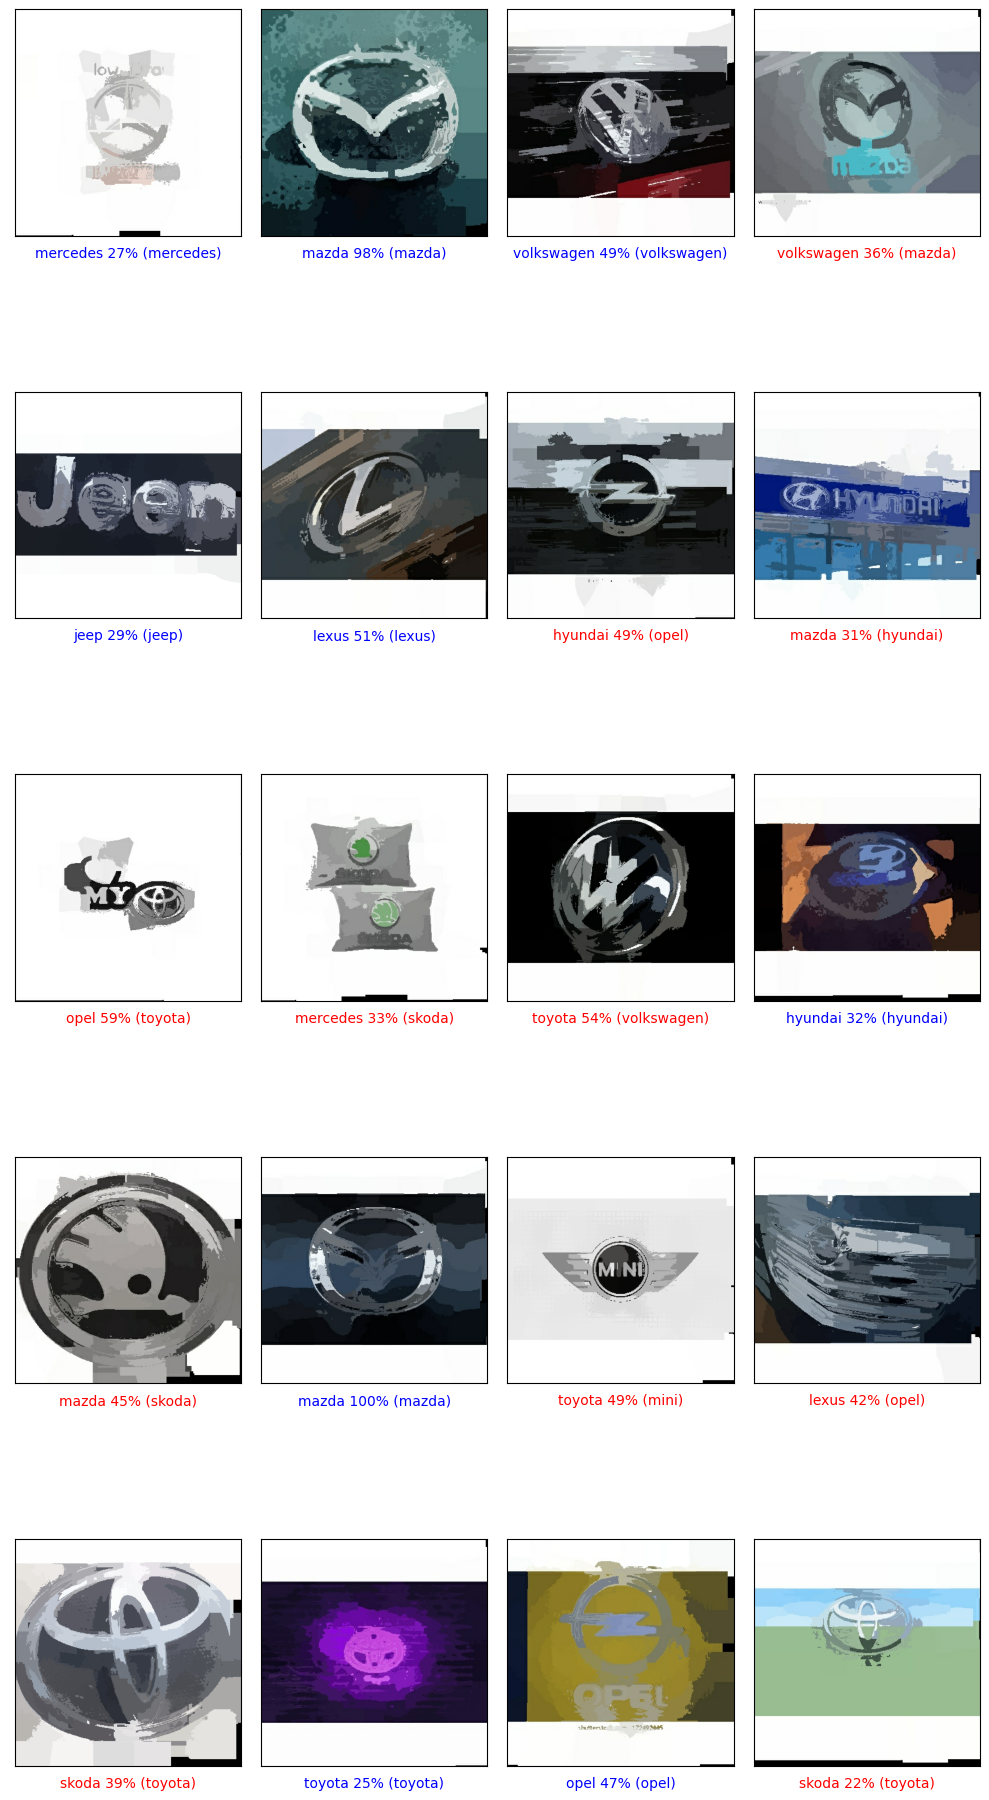

In [101]:
val_batches = tf.data.experimental.cardinality(val_ds)
# Take a fraction for testing
test_dataset = val_ds.take(val_batches // 5).unbatch().batch(1)

# Shuffle the test dataset and take 20 random samples
test_dataset = test_dataset.shuffle(buffer_size=100).take(20)

# Class names
class_names = train_ds.class_names

# Plotting function


def plot_image(prediction_array, true_label, img):
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img.numpy().astype("uint8"))

    predicted_label = np.argmax(prediction_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                         100*np.max(prediction_array),
                                         class_names[true_label]),
               color=color)


# Make predictions and display the images with labels
plt.figure(figsize=(10, 20))
for i, (image, label) in enumerate(test_dataset):
    prediction = model.predict(image)
    true_label = np.argmax(label.numpy(), axis=1)[0]
    plt.subplot(5, 4, i+1)
    plot_image(prediction[0], true_label, image[0])
plt.tight_layout()
plt.show()


In [82]:
# Path to the 'logo-dataset' folder
dataset_dir = './logo-dataset/'

# Loop through each brand folder
for brand_folder in os.listdir(dataset_dir):
    brand_path = os.path.join(dataset_dir, brand_folder)
    if os.path.isdir(brand_path):  # Make sure it's a folder
        images_path = os.path.join(brand_path, 'images')
        if os.path.exists(images_path):  # Check if the 'images' folder exists
            # Move each image from the 'images' folder to the brand folder
            for image in os.listdir(images_path):
                source_path = os.path.join(images_path, image)
                destination_path = os.path.join(brand_path, image)
                shutil.move(source_path, destination_path)
            # Optionally, remove the now-empty 'images' folder
            os.rmdir(images_path)


In [84]:
# # Load data
# batch_size = 32
# img_height = 400
# img_width = 400

# dataset_path = './logo-dataset/'

# full_img_train_ds = tf.keras.preprocessing.image_dataset_from_directory(
#     dataset_path,
#     validation_split=0.2,
#     subset="training",
#     seed=123,
#     image_size=(img_height, img_width),
#     batch_size=batch_size,
#     label_mode='categorical'  # Use 'categorical' for multi-class labels
# )

# full_img_val_ds = tf.keras.preprocessing.image_dataset_from_directory(
#     dataset_path,
#     validation_split=0.2,
#     subset="validation",
#     seed=123,
#     image_size=(img_height, img_width),
#     batch_size=batch_size,
#     label_mode='categorical'
# )

# num_classes = len(full_img_train_ds.class_names)

# full_img_model = models.Sequential([
#     layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
#     layers.Conv2D(16, 3, padding='same', activation='relu'),
#     layers.MaxPooling2D(),
#     layers.Dropout(0.2),  # Dropout layer after pooling
#     layers.Conv2D(32, 3, padding='same', activation='relu'),
#     layers.MaxPooling2D(),
#     layers.Dropout(0.2),  # Another dropout layer
#     # Removed the last Conv2D, MaxPooling2D, and Dropout layers
#     layers.Flatten(),
#     layers.Dense(128, activation='relu'),
#     layers.Dropout(0.5),  # Higher dropout rate before the final layer
#     layers.Dense(num_classes, activation='softmax')
# ])

# full_img_model.compile(optimizer='adam',
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

# epochs = 10
# full_img_history = full_img_model.fit(
#     full_img_train_ds,
#     validation_data=full_img_val_ds,
#     epochs=epochs
# )


Found 3480 files belonging to 34 classes.
Using 2784 files for training.
Found 3480 files belonging to 34 classes.
Using 696 files for validation.
Epoch 1/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 77s 868ms/step - accuracy: 0.0909 - loss: 16.3099 - val_accuracy: 0.0948 - val_loss: 3.4488
Epoch 2/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 75s 865ms/step - accuracy: 0.0977 - loss: 3.4235 - val_accuracy: 0.0963 - val_loss: 3.3656
Epoch 3/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 75s 862ms/step - accuracy: 0.1077 - loss: 3.3359 - val_accuracy: 0.0977 - val_loss: 3.2827
Epoch 4/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 75s 865ms/step - accuracy: 0.1040 - loss: 3.2466 - val_accuracy: 0.0991 - val_loss: 3.2011
Epoch 5/10
78/87 ━━━━━━━━━━━━━━━━━━━━ 7s 828ms/step - accuracy: 0.1123 - loss: 3.1659

KeyboardInterrupt: 